In [55]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
'''
model each half-inning of a baseball game as a state-machine or Markov chain. 
Intuitively, this means that each half-inning goes from one state to the next 
(with a certain probability, depending on what the players on the field do) on every play

tuple (number of outs, base occupancy)

The first state variable, "number of outs", obviously starts at 0 and keeps increasing 
until the batting team has made 3 outs in that half-inning

The other state variable, "base occupancy", starts at 000 (signifying empty bases) and 
during the course of the inning can take values 001 (runner at first, second and third empty), 
010 (runner at second, first and third empty) etc., all the way up to 111 (bases loaded).

we will express these binary-valued triplets as integers, so that 000 maps to 0, 001 to 1,
010 to 2, etc. With this compact notation, the "base occupancy" state variable can assume 
values from 0 to 7.

The key to solving a dynamic programming problem is the evaluation of the value function 
(typically denoted by V), which represents the optimal value of the objective in each state

To simplify the problem, we will assume that once the current batter makes an out or gets on base, 
the subsequent batter will deliver an at-bat consistent with the league average

This allows us to leverage what is known as the run expectancy matrix (R),
which tells us the expected number of runs scored on an average (across MLB) 
in an half-inning, starting from any state (i.e., number of outs and base occupancy)


'''

# Method to compute value function and decision for the "to steal or not to steal" problem 
def run_dynamic_program(R, p, p_steal):

    # Value function
    V = np.zeros([4, 3])

    # Decision to steal vs. no-steal
    steal_decision = np.zeros([3, 1])

    for out in range(2, -1, -1):
        # Runner on 2nd
        V[out, 2] = p[0] * R[out+1, 2] + p[1] * (R[out, 1] + 1) + p[2] * (R[out, 2] + 1) + p[3] * (R[out, 3] + 1) + p[4]*(R[out, 0] + 2)

        # Bases empty
        V[out, 0] = p[0] * R[out+1, 0] + p[1] * R[out, 1] + p[2] * R[out, 2] + p[3] * R[out, 3] + p[4] * (R[out, 0] + 1)

        # Runner on 1st
        value_steal = p_steal * V[out, 2] + (1 - p_steal) * V[out+1, 0]
        value_no_steal = p[0] * R[out+1, 1] + p[1] * R[out, 3] + p[2] * R[out, 6] + p[3] * (R[out, 4] + 1) + p[4] * (R[out, 0] + 2)
        V[out, 1] = np.max([value_steal, value_no_steal])

        # Optimal decision
        steal_decision[out] = (value_steal > value_no_steal)
    return V, steal_decision

SyntaxError: invalid syntax (<ipython-input-62-9bd6d7fb0864>, line 1)

In [57]:
# Run expectancy matrix for teh 2010-2015 MLB seasonx
R = np.matrix([[0.481, 0.254, 0.098, 0],
               [0.859, 0.509, 0.224, 0],
               [1.100, 0.664, 0.319, 0],
               [1.437, 0.884, 0.429, 0],
               [1.350, 0.950, 0.353, 0],
               [1.784, 1.130, 0.478, 0],
               [1.964, 1.376, 0.580, 0],
               [2.292, 1.541, 0.752, 0]])
R = R.transpose()

# Batter stats for Mike Trout's 2016 season 
p_out = 0.559
p_single_or_walk = 0.343
p_double = 0.047
p_triple = 0.007
p_home_run = 0.043

p_batter = np.array([p_out, p_single_or_walk, p_double, p_triple, p_home_run])

# Assumption that the runners [robability of stealing is 50-50 or 50% success
p_steal = 0.5

# Solve dynamic program
V, steal_decision = run_dynamic_program(R, p_batter, p_steal)

# steal decision. I'd be less inclined to have a runner steal when Mike Trout is batting expect with 
# two outs and two strikes. 
print("When the probability of a successful steal is ", 0.5, ":")
for out in range(0, 3):
    if (steal_decision[out]):
        print("With ", out, "out(s), optimal decision is to steal")
    else:
        print("With ", out, "out(s), optimal decision is to not steal")

When the probability of a successful steal is  0.5 :
With  0 out(s), optimal decision is to not steal
With  1 out(s), optimal decision is to not steal
With  2 out(s), optimal decision is to steal


In [58]:
'''
Simulate where we vary the probability of successful steal from 0 to 1
This will allow us to see how the optimal decision evolves with a different number of outs
'''
opt_decision = np.empty([0, 3])
for p_steal in np.arange(0, 1, 0.05):
    V, steal_decision = run_dynamic_program(R, p_batter, p_steal)
    opt_decision = np.append(opt_decision, steal_decision.reshape([1, 3]), axis=0)

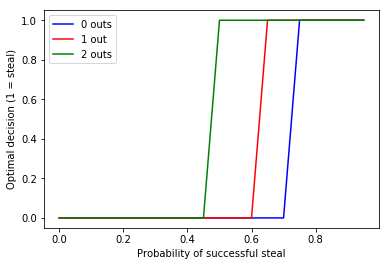

In [59]:
    # Visulaize the results 
    plt.plot(np.arange(0, 1, 0.05), opt_decision[:, 0], 'b', label="0 outs")
    plt.plot(np.arange(0, 1, 0.05), opt_decision[:, 1], 'r', label="1 out")
    plt.plot(np.arange(0, 1, 0.05), opt_decision[:, 2], 'g', label="2 outs")
    plt.xlabel("Probability of successful steal")
    plt.ylabel("Optimal decision (1 = steal)")
    plt.legend(loc="upper left")
    plt.show()